In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv('ibm_cleaned.csv')
df.columns.tolist()

['project_building_identifier',
 'project_school_name',
 'project_type',
 'project_description',
 'project_phase_name',
 'project_phase_actual_start_date',
 'project_phase_planned_end_date',
 'project_budget_amount',
 'final_estimate_of_actual_costs_through_end_of_phase_amount',
 'total_phase_actual_spending_amount',
 'dsf_number_s',
 'failure',
 'borough',
 'over_budget_percentage',
 'over_budget_amount',
 'start_and_planned_end_diff']

In [3]:
df = df[[
    'project_type', 'project_phase_name', 'project_budget_amount', 
    'total_phase_actual_spending_amount', 'failure', 
    'borough', 'over_budget_amount',
    'start_and_planned_end_diff'
]]
df.fillna(0, inplace=True)

In [4]:
# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns

# Convert non-numeric columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

In [5]:
X = df.drop('failure', axis=1)
y = df['failure']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data and resample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# # Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       477
        True       0.91      0.94      0.93       171

    accuracy                           0.96       648
   macro avg       0.95      0.96      0.95       648
weighted avg       0.96      0.96      0.96       648



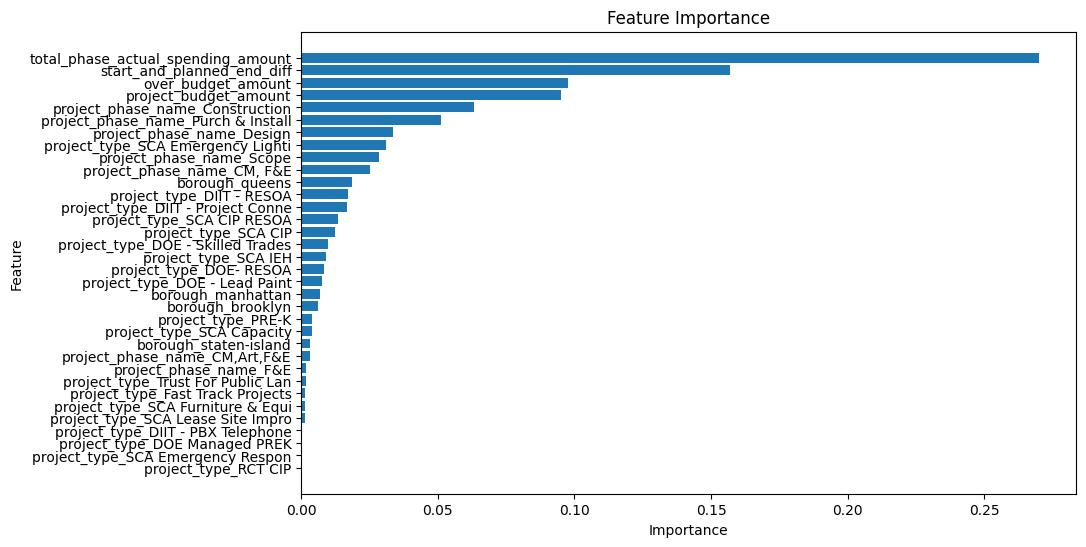

In [10]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [11]:
import shap

# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(model, feature_perturbation='interventional')

/Users/sarahcheng/Library/CloudStorage/OneDrive-UNSW/Jupyter Projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Compute SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

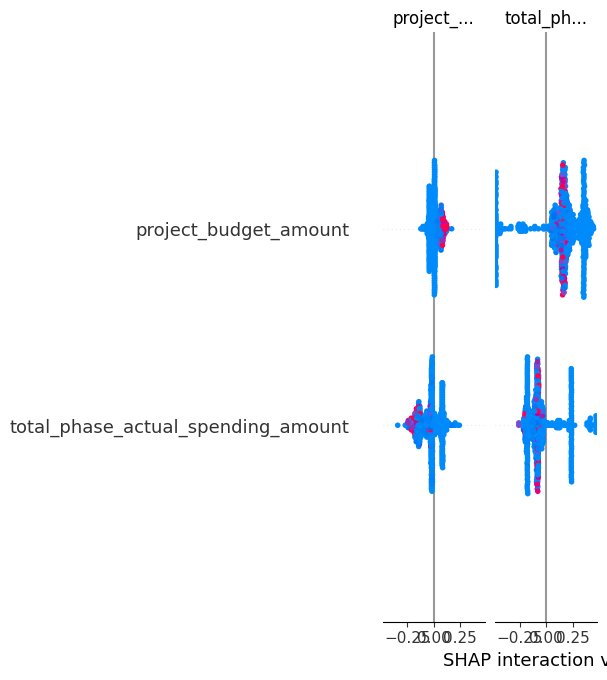

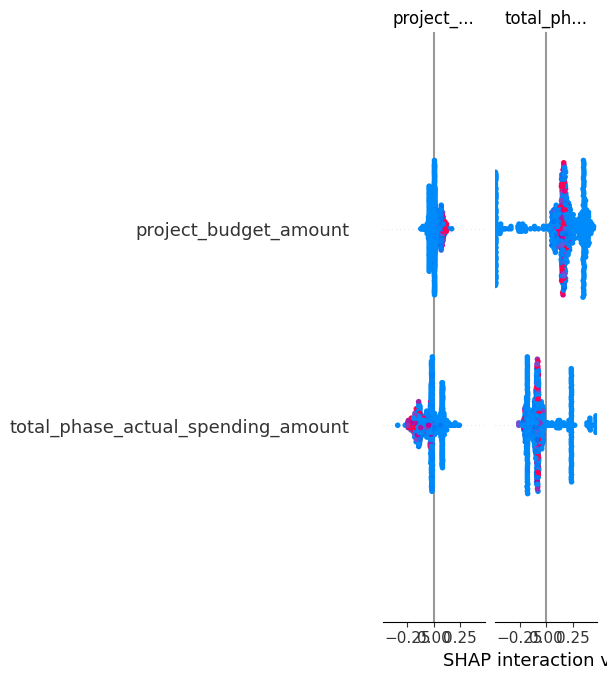

In [13]:
# Summary plot
shap.summary_plot(shap_values, X_test)

# Bar plot for global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [14]:
# Dependence plot for a single feature
shap.dependence_plot("over_budget_amount", shap_values, X_test)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50